# ROC and PR curve on Test Sets
This notebook reproduces figure 2 of our paper. It computes ROC and PR curves for human and _Salmonella_.

It requires numpy, pandas, matplotlib, scikit-learn and matplotlib_venn libraries for python.

In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, average_precision_score, auc
from scipy import interp

import matplotlib.pyplot as plt
plt.rc('font', family='Times New Roman')
import seaborn
from matplotlib_venn import venn2, venn2_circles
%matplotlib inline

/home/sasse/.local/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [19]:
# PARAMETERS
taxon = 561

## 1. Load Test Set Predictions for all tools

### 1.1 Load performance of TriPepSVM

In [20]:
base_train_dir = '../data/balanced_training/pred_{}'.format(taxon)

pred_all = []
sets_all = []
no_cv = 0
for cv_dir in os.listdir(base_train_dir):
    cv_dirname = os.path.join(base_train_dir, cv_dir)
    if os.path.isdir(cv_dirname):
        res_pos = pd.read_csv(os.path.join(cv_dirname, 'results_balanced_{}.RBP.pred.txt'.format(taxon)),
                              sep='\t', header=None,
                              names=['Uniprot_ID', 'Score', 'Class'])
        res_pos['Label'] = 1
        res_neg = pd.read_csv(os.path.join(cv_dirname, 'results_balanced_{}.NRBP.pred.txt'.format(taxon)),
                              sep='\t', header=None,
                              names=['Uniprot_ID', 'Score', 'Class'])
        res_neg['Label'] = -1
        test_res = pd.concat((res_pos, res_neg))
        pred_all.append(test_res)
        no_cv += 1
print ("Read predictions from {} CV runs".format(no_cv))
print ("Each CV run contains {} positive and {} negative proteins".format(res_pos.shape[0], res_neg.shape[0]))

Read predictions from 10 CV runs
Each CV run contains 52 positive and 379 negative proteins


### 1.2 Load performance of RBPPred

In [21]:
# RBPPred
rbppred_pos = pd.read_csv('../data/test/RBPPred/RBP_{}.RBPPred.pred.temp'.format(taxon), sep='\t', header=0)
rbppred_pos['Label'] = 1
rbppred_neg = pd.read_csv('../data/test/RBPPred/NRBP_{}.RBPPred.pred.temp'.format(taxon), sep='\t', header=0)
rbppred_neg['Label'] = -1
rbppred_test_all = pd.concat((rbppred_pos, rbppred_neg))
print ("Loaded predictions for {} RBPs and {} NRBPs".format(rbppred_pos.shape[0], rbppred_neg.shape[0]))

Loaded predictions for 52 RBPs and 379 NRBPs


### 1.3 Load performance of RNApred

In [22]:
# RNApred
rnapred_pos = pd.read_csv('../data/test/RNAPred/RBP_{}.RNAPred.pred.txt'.format(taxon), sep='\t', header=0, names=['Name', 'Score', 'Class'])
rnapred_pos['Label'] = 1
rnapred_neg = pd.read_csv('../data/test/RNAPred/NRBP_{}.RNAPred.pred.txt'.format(taxon), sep='\t', header=0, names=['Name', 'Score', 'Class'])
rnapred_neg['Label'] = -1
rnapred_test_all = pd.concat((rnapred_pos, rnapred_neg))
print ("Loaded predictions for {} RBPs and {} NRBPs".format(rnapred_pos.shape[0], rnapred_neg.shape[0]))

Loaded predictions for 52 RBPs and 379 NRBPs


### 1.4 Load performance of SPOT-seq-RNA

In [23]:
# SPOT-seq-RNA
spot_pos = pd.read_csv('../data/test/SpotSeqRna/RBP_{}.SpotSeqRna.pred.txt'.format(taxon), sep='\t\t', header=None, names=['Name', 'Class'])
spot_pos['Score'] = spot_pos.Class == 'RNA-binding protein'
spot_pos['Label'] = 1
spot_neg = pd.read_csv('../data/test/SpotSeqRna/NRBP_{}.SpotSeqRna.pred.txt'.format(taxon), sep='\t\t', header=None, names=['Name', 'Class'])
spot_neg['Score'] = spot_neg.Class == 'RNA-binding protein'
spot_neg['Label'] = 0
spot_test_all = pd.concat((spot_pos, spot_neg))
print ("Loaded predictions for {} RBPs and {} NRBPs".format(spot_pos.shape[0], spot_neg.shape[0]))

Loaded predictions for 52 RBPs and 379 NRBPs


/pkg/python-3.6.0-0/lib/python3.6/site-packages/ipykernel/__main__.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  from ipykernel import kernelapp as app
/pkg/python-3.6.0-0/lib/python3.6/site-packages/ipykernel/__main__.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


## 2. Compute ROC Curve for all Tools

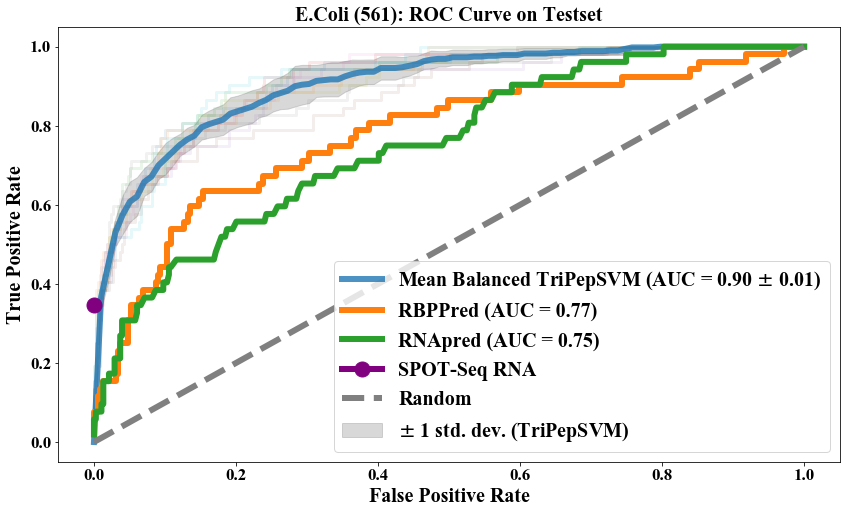

In [24]:
fig = plt.figure(figsize=(14, 8))

linewidth = 6
labelfontsize = 20
ticksize = 17

# TriPepSVM single runs
k = 1
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
for pred in pred_all:
    fpr, tpr, _ = roc_curve(y_score=pred.Score, y_true=pred.Label)
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    auroc = roc_auc_score(y_score=pred.Score, y_true=pred.Label)
    aucs.append(auroc)
    plt.plot(fpr, tpr, lw=linewidth//2, alpha=0.1)
    k += 1

# RBPPred
rbppred_fpr, rbppred_tpr, t_rbppr = roc_curve(y_score=rbppred_test_all.Score, y_true=rbppred_test_all.Label)
rbppred_roc_auc = roc_auc_score(y_score=rbppred_test_all.Score, y_true=rbppred_test_all.Label)

# RNAPred
rnapred_fpr, rnapred_tpr, t_rnapr = roc_curve(y_score=rnapred_test_all.Score, y_true=rnapred_test_all.Label)
rnapred_roc_auc = roc_auc_score(y_score=rnapred_test_all.Score, y_true=rnapred_test_all.Label)

# SPOT-seq
spot_fpr, spot_tpr, t_spot = roc_curve(y_score=spot_test_all.Score, y_true=spot_test_all.Label)
#spot_roc_auc = roc_auc_score(y_score=spot_test_all.Score, y_true=spot_test_all.Label)


# plot mean ROC curve
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr,
         label=r'Mean Balanced TriPepSVM (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=6, alpha=.8)

# plot std dev
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.3,
                 label=r'$\pm$ 1 std. dev. (TriPepSVM)')

# plot competitors
plt.plot(rbppred_fpr, rbppred_tpr, lw=linewidth, label='RBPPred (AUC = {0:.2f})'.format(rbppred_roc_auc))
plt.plot(rnapred_fpr, rnapred_tpr, lw=linewidth, label='RNApred (AUC = {0:.2f})'.format(rnapred_roc_auc))
plt.plot(spot_fpr[-2], spot_tpr[-2], markersize=15, marker='o', lw=linewidth, label='SPOT-Seq RNA', color='purple') # second last point is the only non-inferred one
plt.plot([0, 1], [0, 1], color='gray', lw=linewidth, linestyle='--', label='Random')

plt.xlabel('False Positive Rate', fontsize=labelfontsize)
plt.ylabel('True Positive Rate', fontsize=labelfontsize)
plt.tick_params(axis='both', labelsize=ticksize)
#plt.title('Performance: ROC Curve ({})'.format(taxon), fontsize=labelfontsize)

species_name = 'Human'
if taxon == 561:
    species_name = 'E.Coli'
elif taxon == 590:
    species_name = 'Salmonella'

plt.title('{} ({}): ROC Curve on Testset'.format(species_name, taxon),
          fontsize=labelfontsize)
plt.legend(loc='lower right', prop={'size': 20})
fig.savefig('roc_curve_testset_{}.pdf'.format(taxon))

## 3. Compute PR Curve for all Tools

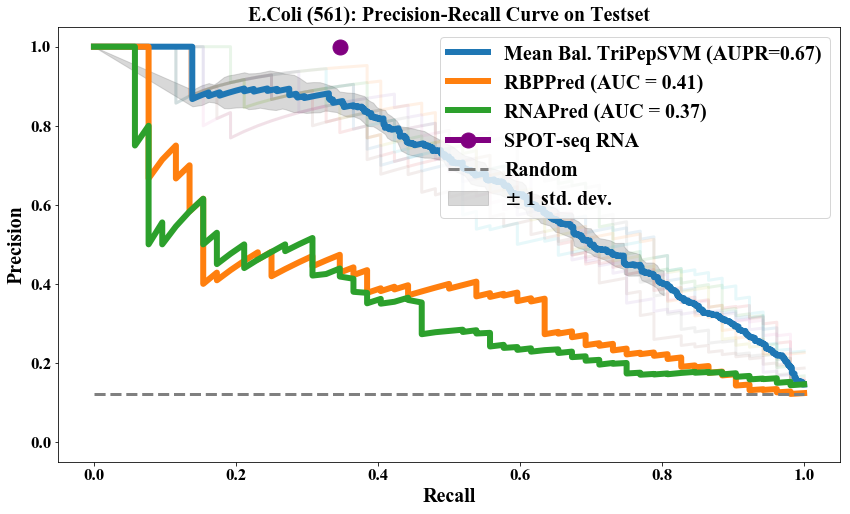

In [25]:
fig = plt.figure(figsize=(14, 8))

linewidth = 6
labelfontsize = 20
ticksize = 17

# TriPepSVM single runs
k = 1
y_true = []
y_pred = []
pr_values = []
rec_values = []
sample_thresholds = np.linspace(0, 1, 100)
no_pos = []
no_total = []
for pred in pred_all:
    pr, rec, thr = precision_recall_curve(probas_pred=pred.Score, y_true=pred.Label)
    no_pos.append(pred.Label.sum())
    no_total.append(pred.shape[0])
    pr_values.append(interp(sample_thresholds, thr, pr[:-1]))
    #pr_values[-1][-1] = 1.0
    rec_values.append(interp(sample_thresholds, thr, rec[:-1]))
    aupr = average_precision_score(y_score=pred.Score, y_true=pred.Label)
    plt.plot(rec, pr, lw=linewidth//2, alpha=0.1)
    y_true.append(pred.Label)
    y_pred.append(pred.Score)
    k += 1
    

# RBPPred
rbppred_pr, rbppred_rec, t_pr_rbppr = precision_recall_curve(probas_pred=rbppred_test_all.Score, y_true=rbppred_test_all.Label)
rbppred_pr_auc = average_precision_score(y_score=rbppred_test_all.Score, y_true=rbppred_test_all.Label)
zero_idx_rbp = (np.abs(t_pr_rbppr - 0.5)).argmin() # probabilities and cutoff is 0.5

# RNApred
rnapred_pr, rnapred_rec, t_pr_rnapr = precision_recall_curve(probas_pred=rnapred_test_all.Score, y_true=rnapred_test_all.Label)
rnapred_pr_auc = average_precision_score(y_score=rnapred_test_all.Score, y_true=rnapred_test_all.Label)
zero_idx_rna = (np.abs(t_pr_rnapr + 0.2)).argmin() # cutoff is -0.2

# SPOT-seq RNA
spot_pr, spot_rec, t_pr_spot = precision_recall_curve(probas_pred=spot_test_all.Score, y_true=spot_test_all.Label)
#spot_pr_auc = average_precision_score(y_score=spot_test_all.Score, y_true=spot_test_all.Label)

# plot mean PR curve for TriPepSVM
y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)
mean_precision, mean_recall, mean_thresholds = precision_recall_curve(y_true, y_pred)
label = 'Mean Bal. TriPepSVM (AUPR=%.2f)' % (auc(mean_recall, mean_precision))
plt.plot(mean_recall, mean_precision, label=label, lw=linewidth)

# plot std dev
std_pr = np.std(pr_values, axis=0)
mean_pr = np.mean(pr_values, axis=0)
mean_rec = np.mean(rec_values, axis=0)
pr_upper = np.minimum(mean_pr + std_pr, 1)
pr_lower = np.maximum(mean_pr - std_pr, 0)
pr_upper = np.append(pr_upper, 1.)
pr_lower = np.append(pr_lower, 1.)
mean_rec = np.append(mean_rec, 0.)
plt.fill_between(mean_rec, pr_lower, pr_upper, color='grey', alpha=.3,
                 label=r'$\pm$ 1 std. dev.')

# plot competitors
plt.plot(rbppred_rec, rbppred_pr, lw=linewidth, label='RBPPred (AUC = {0:.2f})'.format(rbppred_pr_auc))#, color='darkgreen')
plt.plot(rnapred_rec, rnapred_pr, lw=linewidth, label='RNAPred (AUC = {0:.2f})'.format(rnapred_pr_auc))#, color='darkred')
plt.plot(spot_rec[1], spot_pr[1], markersize=15, lw=linewidth, marker='o', label='SPOT-seq RNA', color='purple')
random_y = test_res[test_res.Label == 1].shape[0] / test_res.shape[0]
plt.plot([0, 1], [random_y, random_y], color='gray', lw=3, linestyle='--', label='Random')


plt.xlabel('Recall', fontsize=20)
plt.ylabel('Precision', fontsize=20)
plt.tick_params(axis='both', labelsize=ticksize)
plt.title('{} ({}): Precision-Recall Curve on Testset'.format(species_name, taxon),
          fontsize=labelfontsize)
plt.legend(loc='upper right', prop={'size': 20})
plt.ylim([-0.05, 1.05])
fig.savefig('pr_curve_testset_{}.pdf'.format(taxon))